# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a simple [linear regression model](https://scikit-learn.org/stable/modules/linear_model.html)
        - An advanced regressor of your choice (e.g., Random Forest, Neural Network, etc.)

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

  # Load the data  

Assuming that the files `adult.data` and `adult.test` are in `../data/adult/`, then you can use the code below to load them.

In [1]:
import pandas as pd
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = None, names = columns))


In [6]:
print(fires_dt.head())

  coord_x coord_y  month  day  ffmc   dmc     dc  isi  temp  rh  wind  rain  \
0       X       Y  month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain   
1       7       5    mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7     0   
2       7       4    oct  tue  90.6  35.4  669.1  6.7    18  33   0.9     0   
3       7       4    oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3     0   
4       8       6    mar  fri  91.7  33.3   77.5    9   8.3  97     4   0.2   

   area  
0  area  
1     0  
2     0  
3     0  
4     0  


# Get X and Y

Create the features data frame and target data.

In [2]:
import numpy as np

In [3]:
# Separate numeric and categorical columns
numeric_columns = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area']
categorical_columns = ['month', 'day']

In [4]:
# Ensure numeric columns are numeric
fires_dt[numeric_columns] = fires_dt[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Ensure categorical columns are strings (to prevent issues with OneHotEncoder)
fires_dt[categorical_columns] = fires_dt[categorical_columns].astype(str)

In [5]:
# Check for missing or infinite values in numeric columns
fires_dt[numeric_columns] = fires_dt[numeric_columns].replace([np.inf, -np.inf], np.nan)
if fires_dt[numeric_columns].isnull().values.any():
    fires_dt[numeric_columns] = fires_dt[numeric_columns].fillna(0)

In [6]:
X = fires_dt.drop('area', axis=1)
y = fires_dt['area']
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (518, 12)
Target shape: (518,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [14]:
# preproc1
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp',
    'rh', 'wind', 'rain', 'area'
]

In [9]:
preproc1 = ColumnTransformer([
    ('num', StandardScaler(), ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['month', 'day'])
])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [10]:
# preproc2
preproc2 = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('transform', PowerTransformer())
    ]), ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['month', 'day'])
])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [22]:
linear_reg = LinearRegression()
random_forest = RandomForestRegressor(random_state=42)

In [25]:
# Pipeline A = preproc1 + baseline
pipeline_A = Pipeline([
    ('preprocessor', preproc1),
    ('regressor', linear_reg)
])

In [26]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline([
    ('preprocessor', preproc2),
    ('regressor', linear_reg)
])

In [27]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline([
    ('preprocessor', preproc1),
    ('regressor', random_forest)
])


In [28]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline([
    ('preprocessor', preproc2),
    ('regressor', random_forest)
])

In [29]:
pipelines = [
    ('Pipeline A', pipeline_A),
    ('Pipeline B', pipeline_B),
    ('Pipeline C', pipeline_C),
    ('Pipeline D', pipeline_D)
]

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [13]:
param_grid_A = {'regressor__fit_intercept': [True, False]}


In [14]:
param_grid_B = {'regressor__fit_intercept': [True, False]}

In [15]:
param_grid_C = {
    'regressor__n_estimators': [ 100, 200],
    'regressor__max_features': [None, 10, 20]
}

In [16]:
param_grid_D = {
    'regressor__n_estimators': [ 100, 200],
    'regressor__max_features': [None, 10, 20]
}


# Evaluate

+ Which model has the best performance?

In [18]:
from sklearn.model_selection import GridSearchCV

In [31]:
# Perform GridSearchCV on each pipeline
grids = {
    'pipeline_A': GridSearchCV(pipeline_A, param_grid_A, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1),
    'pipeline_B': GridSearchCV(pipeline_B, param_grid_B, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1),
    'pipeline_C': GridSearchCV(pipeline_C, param_grid_C, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1),
    'pipeline_D': GridSearchCV(pipeline_D, param_grid_D, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
}

best_estimators = {}
for name, grid in grids.items():
    try:
        grid.fit(X_train, y_train)
        best_estimators[name] = grid.best_estimator_
        print(f'Best params for {name}: {grid.best_params_}')
    except Exception as e:
        print(f'Error during GridSearch for {name}: {e}')

# Evaluate the best estimators
if not best_estimators:
    print("No successful grid searches. Exiting.")
else:
    for name, best_estimator in best_estimators.items():
        try:
            y_pred = best_estimator.predict(X_test)
            print(f'--- {name} ---')
            print('MAE:', mean_absolute_error(y_test, y_pred))
            print('RMSE:', mean_squared_error(y_test, y_pred ))
            print('R2:', r2_score(y_test, y_pred))
        except Exception as e:
            print(f'Error during prediction for {name}: {e}')


Best params for pipeline_A: {'regressor__fit_intercept': True}
Best params for pipeline_B: {'regressor__fit_intercept': False}
Best params for pipeline_C: {'regressor__max_features': 10, 'regressor__n_estimators': 200}
Best params for pipeline_D: {'regressor__max_features': 10, 'regressor__n_estimators': 200}
--- pipeline_A ---
MAE: 18.716181161028494
RMSE: 604.6135748144671
R2: -1.5816585275864847
--- pipeline_B ---
MAE: 19.491394175444327
RMSE: 628.5745041340932
R2: -1.6839700536316813
--- pipeline_C ---
MAE: 18.520812155448716
RMSE: 1009.0995982966662
R2: -3.3087861266199745
--- pipeline_D ---
MAE: 18.23777409455128
RMSE: 903.5494695475791
R2: -2.8580943106835726


# Export

+ Save the best performing model to a pickle file.

In [32]:
# Save the best models
for name, best_estimator in best_estimators.items():
    try:
        joblib.dump(best_estimator, f'best_{name}.joblib')
    except Exception as e:
        print(f'Error saving the best model {name}: {e}')

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

*(Answer here.)*

In [33]:
import shap

In [34]:
best_model = joblib.load('best_pipeline_D.joblib')
# Load the best model

In [35]:
# Fit the preprocessor on the training data
preproc1.fit(X_train)

# Transform the training and test data
X_train_transformed = preproc1.transform(X_train)
X_test_transformed = preproc1.transform(X_test)

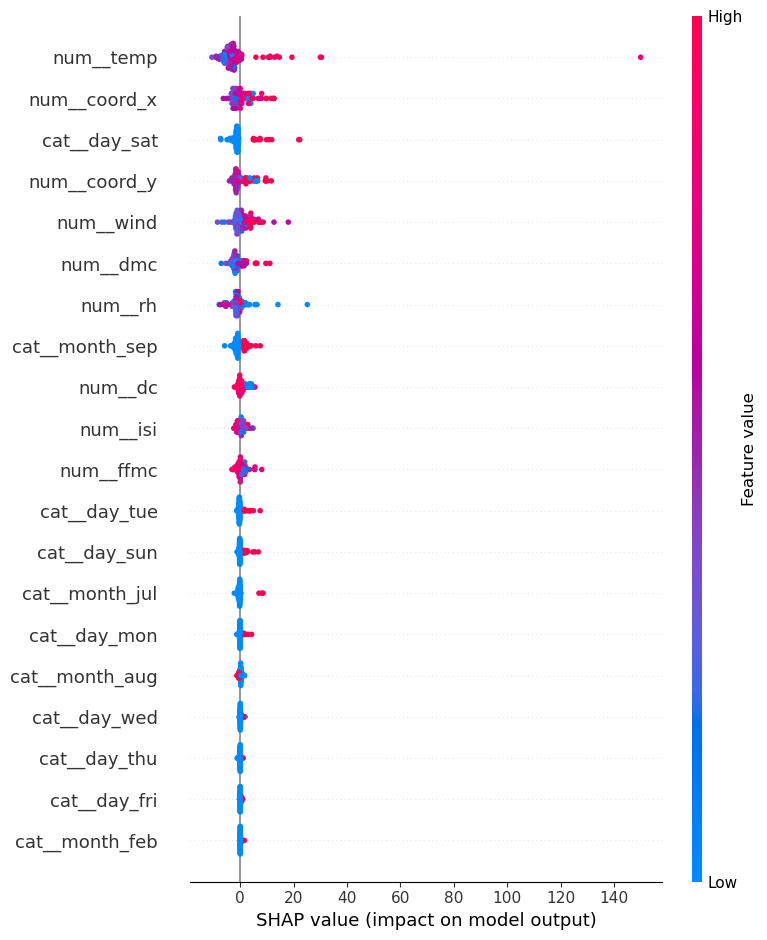

Least important features:
           feature  importance
19  cat__month_nov    0.000231
14  cat__month_jan    0.001229
9        num__rain    0.002237
20  cat__month_oct    0.010445
16  cat__month_jun    0.041309


In [36]:
# Calculate SHAP values
explainer = shap.TreeExplainer(best_model['regressor'])
shap_values = explainer.shap_values(X_test_transformed)

# Select an observation from the test set
observation_index = 0
observation = X_test_transformed[observation_index]

# Explain the specific prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index], observation, feature_names=preproc1.get_feature_names_out())

# General feature importance
shap.summary_plot(shap_values, X_test_transformed, feature_names=preproc1.get_feature_names_out())

# Identify less important features
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame(list(zip(preproc1.get_feature_names_out(), shap_importance)), columns=['feature', 'importance'])
feature_importance = feature_importance.sort_values(by='importance', ascending=True)

# Display least important features
print("Least important features:")
print(feature_importance.head())

Based on the SHAP summary plot provided:

Most Important Features:  
  num__temp (Temperature)  
  num__coord_x (X Coordinate)  
  cat__day_sat (Day: Saturday)  
  num__coord_y (Y Coordinate)  
  num__wind (Wind)  

Least Important Features:  
  cat__day_fri (Day: Friday)  
  cat__month_feb (Month: February)  
  cat__day_thu (Day: Thursday)  
  cat__day_wed (Day: Wednesday)  
  cat__month_aug (Month: August)  

In [37]:
# Removing less important features
least_important_features = feature_importance['feature'].head(3).tolist() 

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.